# 1. Import libs

In [1]:
import pandas as pd
import numpy as np
from optbinning import BinningProcess

(CVXPY) Oct 31 09:16:05 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Oct 31 09:16:05 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
data = pd.read_csv(r'telecom_churn_data.csv')
data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [3]:
# Drop non-essential columns
columns_to_drop = [
    'circle_id', 'last_date_of_month_6', 'last_date_of_month_7', 
    'last_date_of_month_8', 'last_date_of_month_9',
    'date_of_last_rech_6', 'date_of_last_rech_7',
    'date_of_last_rech_8', 'date_of_last_rech_9',
    'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 
    'date_of_last_rech_data_8', 'date_of_last_rech_data_9'
]

# Drop specified columns
data = data.drop(columns=columns_to_drop)

# Fill all missing values with 0
data = data.fillna(0)
data.head()

,mobile_number,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,0.0,0.0,0.0,197.385,214.816,213.803,21.100,0.00,0.00,...,0,1.0,1.0,1.0,0.0,968,30.4,0.0,101.20,3.58
1,7001865778,0.0,0.0,0.0,34.047,355.074,268.321,86.285,24.11,78.68,...,0,0.0,1.0,1.0,0.0,1006,0.0,0.0,0.00,0.00
2,7001625959,0.0,0.0,0.0,167.690,189.058,210.226,290.714,11.54,55.24,...,0,0.0,0.0,0.0,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,0.0,0.0,0.0,221.338,251.102,508.054,389.500,99.91,54.39,...,0,0.0,0.0,0.0,0.0,2491,0.0,0.0,0.00,0.00
4,7000142493,0.0,0.0,0.0,261.636,309.876,238.174,163.426,50.31,149.44,...,0,0.0,0.0,0.0,0.0,1526,0.0,0.0,0.00,0.00


In [4]:
# Step 1: Identify High-Value Customers
data['avg_rech_amt_good_phase'] = (data['total_rech_amt_6'] + data['total_rech_amt_7']) / 2
X = data['avg_rech_amt_good_phase'].quantile(0.7)
data['high_value_customer'] = np.where(data['avg_rech_amt_good_phase'] >= X, 1, 0)

# Filter high-value customers, making an independent copy to avoid warnings
high_value_data = data[data['high_value_customer'] == 1].copy()

# Step 2: Tag Churners based on zero usage in month 9
high_value_data.loc[:, 'churn'] = np.where(
    (high_value_data['total_ic_mou_9'] == 0) &
    (high_value_data['total_og_mou_9'] == 0) &
    (high_value_data['vol_2g_mb_9'] == 0) &
    (high_value_data['vol_3g_mb_9'] == 0), 1, 0
)

# Step 3: Drop month 9 columns to prevent data leakage
churn_data = high_value_data.drop([col for col in high_value_data.columns if '_9' in col], axis=1)

In [5]:
data.head()

,mobile_number,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,...,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,avg_rech_amt_good_phase,high_value_customer
0,7000842753,0.0,0.0,0.0,197.385,214.816,213.803,21.100,0.00,0.00,...,1.0,1.0,0.0,968,30.4,0.0,101.20,3.58,307.0,0
1,7001865778,0.0,0.0,0.0,34.047,355.074,268.321,86.285,24.11,78.68,...,1.0,1.0,0.0,1006,0.0,0.0,0.00,0.00,229.0,0
2,7001625959,0.0,0.0,0.0,167.690,189.058,210.226,290.714,11.54,55.24,...,0.0,0.0,1.0,1103,0.0,0.0,4.17,0.00,241.5,0
3,7001204172,0.0,0.0,0.0,221.338,251.102,508.054,389.500,99.91,54.39,...,0.0,0.0,0.0,2491,0.0,0.0,0.00,0.00,270.0,0
4,7000142493,0.0,0.0,0.0,261.636,309.876,238.174,163.426,50.31,149.44,...,0.0,0.0,0.0,1526,0.0,0.0,0.00,0.00,273.0,0


In [6]:
# Split into train and test (using time-based or random split)
# Example using random split:
from sklearn.model_selection import train_test_split
# Separate features and target variable
X = churn_data.drop(columns=['churn'])
y = churn_data['churn']

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Check class distribution in training set to understand imbalance
print(y_train.value_counts(normalize=True))

churn
0    0.913612
1    0.086388
Name: proportion, dtype: float64


Using SMOTE

In [7]:
# from imblearn.over_sampling import SMOTE

# # Applying SMOTE to balance the training data
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)


VIF Feature Engineering

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_train = X_train.select_dtypes(include=['number'])
# If necessary, drop any rows with NaN values
X_train = X_train.dropna()

# Calculating VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X_train.columns
vif_data['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# Convert VIF column to numeric, setting errors='coerce' to handle any non-numeric values
vif_data['VIF'] = pd.to_numeric(vif_data['VIF'], errors='coerce')

# # Display features with VIF > 10 (indicating high multicollinearity)
# high_vif = vif_data[vif_data['VIF'] > 10]

# # Show the result
print(vif_data)


c:\Master of Data Science\Docs\Python\env\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Master of Data Science\Docs\Python\env\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                     feature        VIF
0              mobile_number   1.125817
1             loc_og_t2o_mou        NaN
2             std_og_t2o_mou        NaN
3             loc_ic_t2o_mou        NaN
4                     arpu_6  15.674425
..                       ...        ...
159               jul_vbc_3g   3.873991
160               jun_vbc_3g   2.979866
161               sep_vbc_3g   1.111345
162  avg_rech_amt_good_phase        inf
163      high_value_customer   0.000000

[164 rows x 2 columns]


c:\Master of Data Science\Docs\Python\env\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Model building
Logistic Regression

In [9]:
# Re-split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Drop rows with any missing values in X_train and update y_train
X_train = X_train.dropna()
y_train = y_train[X_train.index]  # Align y_train with the new X_train

# Check for NaNs after dropping
print("NaNs in X_train after dropping:", X_train.isna().sum().sum())
print("NaNs in y_train after aligning:", y_train.isna().sum())

# Drop rows with any missing values in X_test as well
X_test = X_test.dropna()
y_test = y_test[X_test.index]  # Align y_test with the new X_test

# Check for NaNs in test data
print("NaNs in X_test after dropping:", X_test.isna().sum().sum())
print("NaNs in y_test after aligning:", y_test.isna().sum())

# Train logistic regression with class weights
log_reg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

# Predictions and evaluation on test data
y_pred = log_reg.predict(X_test)
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred))
print("Logistic Regression AUC-ROC:", roc_auc_score(y_test, y_pred))


NaNs in X_train after dropping: 0
NaNs in y_train after aligning: 0
NaNs in X_test after dropping: 0
NaNs in y_test after aligning: 0
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.74      0.84      5484
           1       0.22      0.79      0.35       519

    accuracy                           0.75      6003
   macro avg       0.60      0.77      0.60      6003
weighted avg       0.91      0.75      0.80      6003

Logistic Regression AUC-ROC: 0.7667597382611739


Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Train random forest with class weights
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Predictions and evaluation on test data
y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest AUC-ROC:", roc_auc_score(y_test, y_pred_rf))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      5484
           1       0.77      0.44      0.56       519

    accuracy                           0.94      6003
   macro avg       0.86      0.72      0.77      6003
weighted avg       0.93      0.94      0.93      6003

Random Forest AUC-ROC: 0.715288933017965


Evaluation Metrics

In [12]:
from sklearn.metrics import roc_auc_score, f1_score

# Logistic Regression metrics
roc_auc_log = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])
f1_log = f1_score(y_test, y_pred)

# Random Forest metrics
roc_auc_rf = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
f1_rf = f1_score(y_test, y_pred_rf)

print("Logistic Regression AUC-ROC:", roc_auc_log)
print("Logistic Regression F1 Score:", f1_log)
print("Random Forest AUC-ROC:", roc_auc_rf)
print("Random Forest F1 Score:", f1_rf)

Logistic Regression AUC-ROC: 0.8466953786738511
Logistic Regression F1 Score: 0.35023434171282486
Random Forest AUC-ROC: 0.9255318326636677
Random Forest F1 Score: 0.5623471882640587


Feature Importance Visualization
Logistic Regression Coefficients

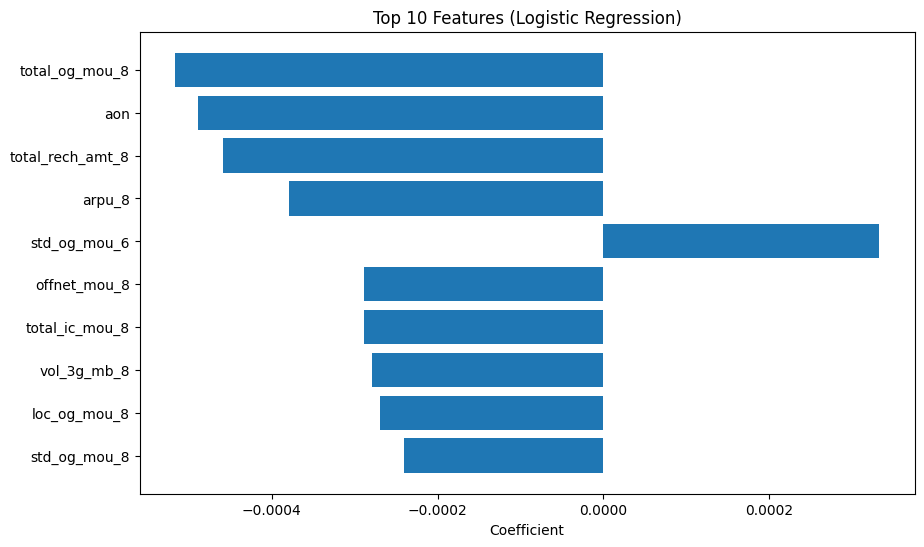

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Logistic regression feature importance (coefficients)
coefficients = log_reg.coef_[0]
features = X_train.columns

# Sort by absolute value to highlight most impactful features
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
coef_df['AbsCoefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'][:10], coef_df['Coefficient'][:10])
plt.xlabel('Coefficient')
plt.title('Top 10 Features (Logistic Regression)')
plt.gca().invert_yaxis()
plt.show()

Random Forest Feature Importances

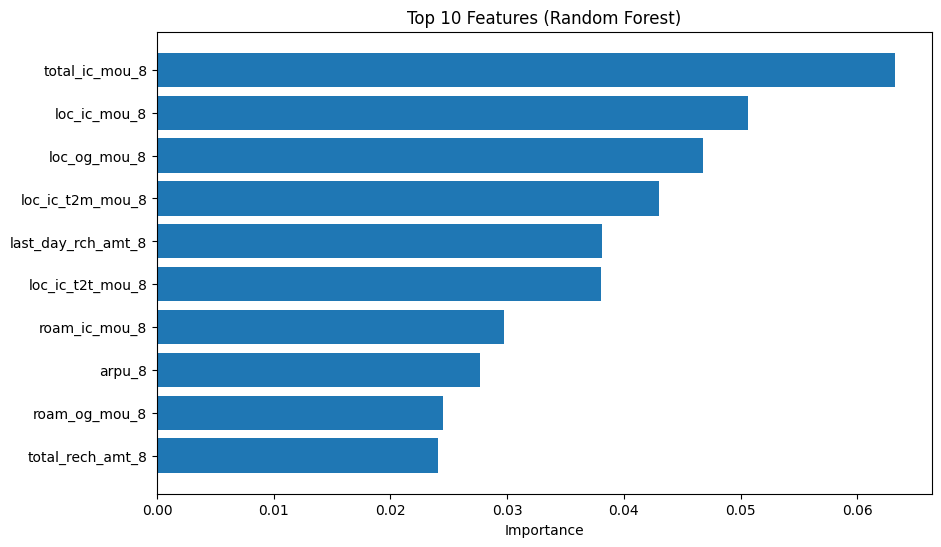

In [14]:
# Random forest feature importance
importances = rf.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort and plot top 10 features
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Features (Random Forest)')
plt.gca().invert_yaxis()
plt.show()